In [1]:
from visualizer import calibration
import visual

from PyQt5 import QtCore
import tifffile
from skimage.io import imread
from skimage.io.collection import alphanumeric_key
from dask import delayed
from glob import glob
import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
import napari
from napari import Viewer
import os
import zarr
from skimage.registration import phase_cross_correlation
import cv2 as cv
from skimage import io
from skimage.morphology import skeletonize
from skan import Skeleton
import scipy.ndimage as ndi
import cupy as cp 
import waveorder as wo
from waveorder.io.multipagetiff import  MicromanagerOmeTiffReader
from aicsimageio import AICSImage,imread, imread_dask
import cv2 as cv
import analysis_utils as au
import bottleneck as bn
import pandas as pd

%gui qt 
%matplotlib inline
plt.style.use('dark_background')
from skimage.measure import find_contours

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


c:\Users\yoshi\Documents\edhirata\M25\m25-napari\notebooks\analysis_utils.py:77: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if side is 'L':
c:\Users\yoshi\Documents\edhirata\M25\m25-napari\notebooks\analysis_utils.py:82: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif side is 'R':
c:\Users\yoshi\Documents\edhirata\M25\m25-napari\notebooks\analysis_utils.py:87: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif side is 'LR':


In [2]:
### Enter the filepath for the data directory
main_dir =r'F:\DATA\20220507_M25_ZW495_9'   #5 fast dynamics of big worm
###Enter the filepath for background images
bg_dir = r'F:\Test_ignore\20220513_M25_bg_16bit'
### Enter the filepath for Calibration Dataset (PSF) or offset file
psf_dir = r'F:\Test_ignore\220508_190nmSteps_postitive2negative_1'
# psf_dir = r'F:\Test_ignore\220508_380nmSteps_minusplus_reversed_1'
#Get Folders and files
main_dirs = sorted(glob(main_dir + '/CAM*/'), key=alphanumeric_key)
bg_folders = sorted(glob(bg_dir + '/CAM*/'), key=alphanumeric_key)

# Load offsets from desired folder 
processed_files = main_dir + '/'+'processed_files'
if not os.path.exists(processed_files):
    os.makedirs(processed_files)

offset_dir = os.path.join(psf_dir + '/'+'processed_files')
offsets_file = os.path.join(offset_dir,"offsets.csv")
offsets_file_pcc = os.path.join(offset_dir,"offsets_pcc.csv")

if os.path.exists(offsets_file):
    with open(offsets_file) as file_name:
        print("loading offsets")
        offsets = np.loadtxt(file_name, delimiter=",")

if os.path.exists(offsets_file_pcc):
    with open(offsets_file) as file_name:
        print("loading offsets")
        offsets_pcc = np.loadtxt(file_name, delimiter=",")
## Quick Visualizer of the selected planes
# center_planes = calibration.lazy_dask_stack(main_dir,num_cams=5,px_depth='uint16', height=608, width =608)
# napari.add_image(center_planes, name='center_planes',scale=[z_scale,1,1],multiscale=False)

In [3]:
# Scope Parameters
cam_px = 6.0e-6
totalmag = 15.75
zstep = 2e-6

px_size_img = cam_px/totalmag
z_scale = zstep/px_size_img

### LOAD DATASET

In [4]:
### For preexisting tiff saved datasets
filename = 'aligned_stack.zarr'
filepath_save = os.path.join(processed_files,filename)
zarr_stack = zarr.load(filepath_save)
#Compensate center plane
zarr_stack[:,12,:,:]=zarr_stack[:,12,:,:]*1.23077

In [5]:
crop_stack =zarr_stack[120:220,6:21,:,:]  #for the single plane

In [6]:
viewer = napari.Viewer()

Assistant skips harvesting pyclesperanto as it's not installed.


c:\ProgramData\Anaconda3\envs\m25-py39\lib\site-packages\napari_tools_menu\__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [11]:
da_crop_stack= da.asarray(crop_stack)
viewer.add_image(da_crop_stack)

<Image layer 'da_crop_stack' at 0x1f474c254f0>

## Crop section

In [8]:
import analysis_utils as au

In [12]:
#Go to napari and make a square for alignment
crop_region =viewer.layers['Shapes'].data[0]
print(crop_region.shape)
print(crop_region.ndim)
# crop_region = np.insert(crop_region,1,0,axis=1)
# box = au.getSubImage(crop_stack,crop_region)
template = calibration.create_box_ndarray(crop_region)
box = template[0:4,2:4]
print(crop_region)
print(box)

min_val, max_val = box
crop_img = crop_stack[0,:, min_val[0]:max_val[0],min_val[1]:max_val[1]]
viewer.add_image(crop_img)

(4, 4)
2
[[ 50.           7.         301.53439718 154.11424803]
 [ 50.           7.         301.53439718 328.6596993 ]
 [ 50.           7.         454.85134762 328.6596993 ]
 [ 50.           7.         454.85134762 154.11424803]]
[[302 154]
 [455 329]]


<Image layer 'crop_img' at 0x1f4751d5070>

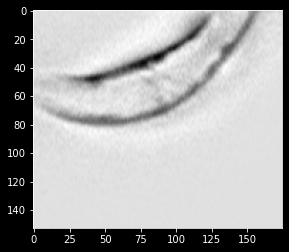

In [25]:
import cv2

c,y,x  = crop_img.shape

lap_img = cv2.Laplacian(crop_img,cv2.CV_64F,ksize=11)
z_max_var = []
for i in range(lap_img.shape[0]):
   z_max_var.append(np.var(lap_img[i]))
max_var = max(z_max_var)
max_id = z_max_var.index(max_var)
plt.imshow(lap_img[max_id], cmap='gray')
# viewer.add_image(lap_img)
# plt.imshow(max_id)


(1, 15, 153, 175)
9


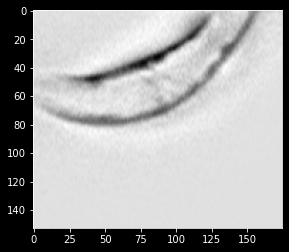

In [26]:
# import cv2

c,y,x  = crop_img.shape

crop_img2 = crop_img[np.newaxis,:,:,:]
print(crop_img2.shape)
lap_img = cv2.Laplacian(crop_img,cv2.CV_64F,ksize=11)
z_max_var = []
for i in range(lap_img.shape[0]):
   z_max_var.append(np.var(lap_img[i]))
max_var = max(z_max_var)
max_id = z_max_var.index(max_var)
print(max_id)
plt.imshow(lap_img[max_id], cmap='gray')


In [27]:
wo.image_stack_viewer(lap_img)

interactive(children=(IntSlider(value=0, description='stack_idx', max=14), Output()), _dom_classes=('widget-in…

<function waveorder.visual.image_stack_viewer.<locals>.interact_plot_3D(stack_idx)>

In [28]:
def z_focus_id(img_stack,t,ksize=11)->int:
    _,c,y,x  = img_stack.shape
    img_stack = cv2.Laplacian(img_stack[t,:],cv2.CV_64F,ksize=ksize)
    z_max_var = []
    for i in range(c):
        z_max_var.append(np.var(img_stack[i]))
    max_var = max(z_max_var)
    max_id = z_max_var.index(max_var)
    return max_id 



In [29]:
a = z_focus_id(crop_img2, ksize=11)

TypeError: z_focus_id() missing 1 required positional argument: 't'

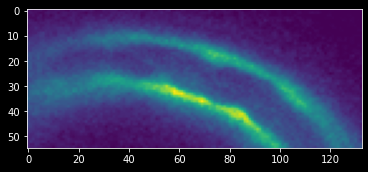

In [ ]:
plt.imshow(crop_img2[0,a])

In [30]:
from vispy.color import Colormap
from skimage import data

# create the viewer and window
viewer = napari.Viewer()

# add the image
img_layer = viewer.add_image(data.camera(), name='photographer')

# create a list of polygons
polygons = [
    np.array([[11, 13], [111, 113], [22, 246]]),
    np.array(
        [
            [505, 60],
            [402, 71],
            [383, 42],
            [251, 95],
            [212, 59],
            [131, 137],
            [126, 187],
            [191, 204],
            [171, 248],
            [211, 260],
            [273, 243],
            [264, 225],
            [430, 173],
            [512, 160],
        ]
    ),
    np.array(
        [
            [310, 382],
            [229, 381],
            [209, 401],
            [221, 411],
            [258, 411],
            [300, 412],
            [306, 435],
            [268, 434],
            [265, 454],
            [298, 461],
            [307, 461],
            [307, 507],
            [349, 510],
            [352, 369],
            [330, 366],
            [330, 366],
        ]
    ),
]

# add polygons
layer = viewer.add_shapes(
    polygons,
    shape_type='polygon',
    edge_width=1,
    edge_color='coral',
    face_color='royalblue',
    name='shapes',
)

# change some attributes of the layer
layer.selected_data = set(range(layer.nshapes))
layer.current_edge_width = 5
layer.current_opacity = 0.75
layer.selected_data = set()

# add an ellipse to the layer
ellipse = np.array([[59, 222], [110, 289], [170, 243], [119, 176]])
layer.add(
    ellipse,
    shape_type='ellipse',
    edge_width=5,
    edge_color='coral',
    face_color='purple',
)

masks = layer.to_masks([512, 512])
masks_layer = viewer.add_image(masks.astype(float), name='masks')
masks_layer.opacity = 0.7
masks_layer.colormap = Colormap([[0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 1.0]])

labels = layer.to_labels([512, 512])
labels_layer = viewer.add_labels(labels, name='labels')
labels_layer.visible = False


c:\ProgramData\Anaconda3\envs\m25-py39\lib\site-packages\napari_tools_menu\__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [42]:
circle_center =[[15,100],[10,10]]
layer = viewer.add_shapes(
    circle_center,
    shape_type='ellipse',
    edge_width=1,
    edge_color='coral',
    face_color='purple',
)


In [45]:
layer.data

[array([[  5.,  90.],
        [ 25.,  90.],
        [ 25., 110.],
        [  5., 110.]])]

In [44]:
crop_region =viewer.layers['cirle_center'].data[0]
print(crop_region)


KeyError: "'cirle_center' is not in list"

In [15]:
text_properties = {
    'text': '{class}: {likelihood:0.1f}%',
    'anchor': 'upper_left',
    'translation': [-5, 0],
    'size': 8,
    'color': 'green',
}

In [19]:
polygons = [
    np.array([[225, 146], [283, 146], [283, 211], [225, 211]]),
    np.array([[67, 182], [167, 182], [167, 268], [67, 268]]),
    np.array([[111, 336], [220, 336], [220, 240], [111, 240]]),
]
# create properties
properties = {
    'likelihood': [21.23423, 51.2315, 100],
    'class': ['hand', 'face', 'camera'],
}
edge_color_cycle = ['blue', 'magenta', 'green']

# add polygons
shapes_layer = viewer.add_shapes(
    polygons,
    properties=properties,
    shape_type='polygon',
    edge_width=3,
    edge_color='class',
    edge_color_cycle=edge_color_cycle,
    face_color='transparent',
    text=text_properties,
    name='shapes',
)

In [20]:
# create a list of polygons
polygons = [
    np.array([[11, 13], [111, 113], [22, 246]]),
    np.array(
        [
            [505, 60],
            [402, 71],
            [383, 42],
            [251, 95],
            [212, 59],
            [131, 137],
            [126, 187],
            [191, 204],
            [171, 248],
            [211, 260],
            [273, 243],
            [264, 225],
            [430, 173],
            [512, 160],
        ]
    ),
    np.array(
        [
            [310, 382],
            [229, 381],
            [209, 401],
            [221, 411],
            [258, 411],
            [300, 412],
            [306, 435],
            [268, 434],
            [265, 454],
            [298, 461],
            [307, 461],
            [307, 507],
            [349, 510],
            [352, 369],
            [330, 366],
            [330, 366],
        ]
    ),
]

# create properties
properties = {
    'likelihood': [0.2, 0.5, 1],
    'class': ['sky', 'person', 'building'],
}
face_color_cycle = ['blue', 'magenta', 'green']

# add polygons
layer = viewer.add_shapes(
    polygons,
    properties=properties,
    shape_type='polygon',
    edge_width=1,
    edge_color='likelihood',
    edge_colormap='gray',
    face_color='class',
    face_color_cycle=face_color_cycle,
    name='shapes',
)

# change some properties of the layer
layer.selected_data = set(range(layer.nshapes))
layer.current_edge_width = 5
layer.selected_data = set()

In [23]:
viewer.layers['Shapes'].shape_type

['ellipse']